# Brain MNIST Classification
In this data set we will be using the MindBigData dataset (https://mindbigdata.com/opendb/index.html). I will be solely using just the MindWave file. This dataset contains EEG data when a person is shown a digit (0-9). The goal is to classify based on EEG data what digit was shown to the person.

## Importing Dataset

In [3]:
#importing dataset with pandas
import pandas as pd

data=pd.read_csv("MW.txt", sep='\t', header=None, names=["id", "event", "channel", "num", "size", "eeg"])

#plotting top 5 samples
data.head()

,id,event,channel,num,size,eeg
0,0,MW,FP1,0,1017,"38,48,51,44,48,56,56,41,20,-3,-9,-1,6,5,6,17,2..."
1,1,MW,FP1,1,889,"83,74,65,65,66,55,43,25,18,20,26,33,41,38,28,3..."
2,2,MW,FP1,4,1017,"19,10,-2,-9,-5,3,8,7,8,2,-10,-21,-22,-27,-30,-..."
3,3,MW,FP1,1,1017,"17,29,36,26,21,17,17,13,17,21,25,26,20,5,-5,-1..."
4,4,MW,FP1,8,952,"77,74,69,70,76,75,76,75,67,66,76,93,98,82,55,3..."


## Preprocessing the EEG Data

### Extracting data of the same size from EEG Data

In [4]:
#looking at the different sizes of data
data["size"].value_counts()

size
952     14403
953     13610
1024    12701
1017     8825
1015     8617
889      6445
951      1068
1016      820
1014      597
888       530
825         7
826         5
763         2
504         1
441         1
569         1
890         1
700         1
Name: count, dtype: int64

The dataset should contain 2 seconds of data with a sampling rate of 512Hz. Theoretically, there should be about 1024 samples of data. This is not the case when looking at the different sizes within the size column. For the sake of this project, I will be working with data that is 952 samples long because it has the highest quantity of data.

When further evaluating the data, eeg data with 1024 samples all belong to the (-1) class which will not be in the scope of this project.

In [5]:
#creating new dataset with eeg data that is 952 samples long
new_size = 952
new_data = data.loc[data["size"] == new_size]
new_data

,id,event,channel,num,size,eeg
4,4,MW,FP1,8,952,"77,74,69,70,76,75,76,75,67,66,76,93,98,82,55,3..."
6,6,MW,FP1,5,952,"-68,-65,-55,-52,-60,-67,-58,-46,-28,-19,-19,-2..."
9,9,MW,FP1,7,952,"25,24,2,-19,-11,2,1,-4,-12,-18,-8,5,11,9,4,0,1..."
14,14,MW,FP1,7,952,"34,84,117,90,32,-4,7,41,44,20,-5,-13,6,28,36,3..."
21,21,MW,FP1,8,952,"42,26,3,-1,12,33,40,37,24,17,16,9,3,12,38,64,8..."
...,...,...,...,...,...,...
54917,54917,MW,FP1,4,952,"1,-17,-10,24,60,56,19,-13,-2,54,88,72,33,12,9,..."
54918,54918,MW,FP1,0,952,"2,-3,-9,-1,6,11,12,6,-8,-17,-19,-18,-17,-25,-2..."
54921,54921,MW,FP1,7,952,"16,23,37,41,38,27,16,17,25,27,27,25,23,35,52,6..."
54928,54928,MW,FP1,3,952,"26,25,33,41,42,39,44,60,53,33,25,27,26,18,9,5,..."


## Extracting the EEG data from the Pandas Dataframe

In [11]:
#testing extracting one eeg-stream into a numpy array
import numpy as np
eeg_data = np.zeros(shape=(new_size, new_data["eeg"].size))
temp = new_data["eeg"].to_numpy()

#iterating through preallocated array
for i in range(new_data["eeg"].size):
    eeg_data[:,i] = np.fromstring(temp[i], dtype=int, sep=',')

#transposing so samples are among the columns
eeg_data = np.transpose(eeg_data)
eeg_data.shape

(14403, 952)

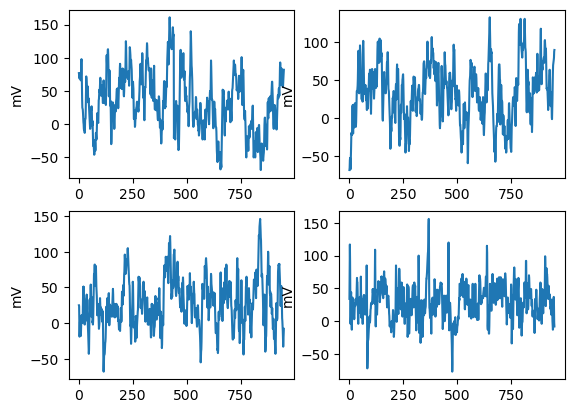

In [12]:
#plotting some eeg data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)

i=0;
for ax in ax.flat:
    ax.plot(eeg_data[i,:])
    ax.set(ylabel='mV')
    i+=1

### Train-Test Split
Before we perform any pre-processing on the raw eeg data, it is important to split the dataset within training and testing split to reduce the likelihood of data leakage.

In [13]:
#sklearn train-test split
from sklearn.model_selection import train_test_split

#extract labels from pandas dataframe
labels = new_data["num"].to_numpy()

eeg_train, eeg_test, labels_train, labels_test = train_test_split(
                                                    eeg_data,
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=24)

### Filtering the EEG Data